# Price Dynamics Analysis

## CAISO Day-ahead electricity market

### Combining RandomForest and XGBoost

- Data preprocessing
- Train-test split
- Forecast
  - Ensemble & Stacked without volatility
  - Stacked model with volatility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import warnings

from scipy.stats.mstats import winsorize

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

Set specifics for visuals

In [4]:
palette = "Dark2"

plt.rc("figure", figsize=(16,8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=20)
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="small", titleweight="bold", titlesize=20, titlepad=15)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings('ignore')
plt.close('all')

sns.set(style="whitegrid", palette=palette, font_scale=1.8)
figpath = "../Figures/"

Define paths and other input parameters

In [6]:
pacific_tz = "America/Los_Angeles"

file_path = '../Data/CAISO/'
file_name = 'caiso_lmp_da_hr_zones_*.csv' 

areas = ['ZP-26']

columns_to_keep = [
    "UTC Timestamp (Interval Ending)", "Local Timestamp Pacific Time (Interval Ending)",
     "ZP-26 LMP"
]

split_date = '2025-02-25 00:00:00'
test_end = '2025-03-04 00:00:00'
time_delta = 1

best_arima_order = (1,0,1) 
best_garch_order = (1,1)

Keep user-defined functions here

In [8]:
def set_index(df, time_col="UTC_Ending"):
    if time_col not in df.columns:
        raise ValueError("Invalid time column selection. Choose 'UTC_Ending' or 'Local_Ending'")
    return df.set_index(time_col)

def impute_hourly_avg(df, cols):
    
    for col in cols:
        for idx in df[df[col].isna()].index:
            prev_day = idx - pd.Timedelta(days=1)
            next_day = idx + pd.Timedelta(days=1)
            prev2_day = idx - pd.Timedelta(days=2) 
            
            values = []
            
            if prev_day in df.index and not pd.isna(df.loc[prev_day, col]):
                values.append(df.loc[prev_day, col])
            if next_day in df.index and not pd.isna(df.loc[next_day, col]):
                values.append(df.loc[next_day, col])
                
            # if insufficient values, check two days before
            
            if len(values)<2:
                if prev2_day in df.index and not pd.isna(df.loc[prev2_day, col]):
                    values.append(df.loc[prev2_day, col])
            
            
            if values:
                df.loc[idx, col] = sum(values)/len(values)
                
    return df

def winsorize_outliers(df, cols, limits=(0.01, 0.01)):
    '''
    Winsorization is an excellent way to remove outliers while preserving data integrity. Instead of
    removing them, it replaces extreme values with the nearest percentile-based threshold. Usually, the
    1st percentile (low end) and 99th percentile (high end) are used.
    '''
    
    for col in cols:
        df[col] = winsorize(df[col], limits=limits)
        
    return df

def get_ext_timecols(df):
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def get_train_test(df, split_date, test_end, time_delta):
    
    new_split = pd.to_datetime(split_date) - pd.Timedelta(days=time_delta)

    df_train = df[df.index < new_split].copy()
    df_test = df[(df.index >= new_split) & (df.index <= test_end)].copy()
    
    return df_train, df_test

def comparative_plot1(df_test, area, actual_values, prediction, var1='Actual values', var2='Forecast', name='Model'):
    
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df_test.index, prediction, lw=2, label=var2)
    ax.plot(df_test.index, actual_values, lw=2, linestyle='--', label=var1)
    ax.legend(loc='lower left', fontsize=30)
    ax.set_title(f'Forecast vs Actual for {area}', fontsize=40)
    ax.set_ylabel('LMP ($/MWh)', fontsize=30)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=30)
    
    inset_ax = inset_axes(ax, width='25%', height='35%', loc='upper right')
    inset_ax.scatter(actual_values, prediction, alpha=0.5)
    inset_ax.set_xlabel('Actual', fontsize=30)
    inset_ax.set_ylabel('Predicted', fontsize=30)
    inset_ax.tick_params(axis='both', labelsize=30)
    
    plt.tight_layout()
    plt.savefig(figpath + "Forecast_" + area + "_" + var2 + "_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def comparative_plot2(df_test, area, actual_values, prediction_rf, prediction_gb, var1='Actual values', var2='Forecast1', var3='Forecast3', name='Model'):
    
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df_test.index, prediction_rf, lw=2, label=var2)
    ax.plot(df_test.index, prediction_gb, lw=2, label=var3)
    ax.plot(df_test.index, actual_values, lw=2, linestyle='--', label=var1)
    ax.legend(loc='lower left', fontsize=30)
    ax.set_title(f'Forecast vs Actual for {area}', fontsize=40)
    ax.set_ylabel('LMP ($/MWh)', fontsize=30)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=30)
    
    inset_ax = inset_axes(ax, width='25%', height='35%', loc='upper right')
    inset_ax.scatter(actual_values, prediction_rf, alpha=0.5, label=var2)
    inset_ax.scatter(actual_values, prediction_gb, alpha=0.5, label=var3)
    inset_ax.set_xlabel('Actual', fontsize=30)
    inset_ax.set_ylabel('Predicted', fontsize=30)
    inset_ax.tick_params(axis='both', labelsize=30)
    inset_ax.legend(fontsize=30)
    
    plt.tight_layout()
    plt.savefig(figpath + "Forecast_" + area + "_" + var2 + "_" + var3 + "_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def transform_series(series):
     
    min_val = series.min()
    shift_val = abs(min_val) + 0.01 if min_val <= 0 else 0
    
    transformed_series = np.log(series + shift_val)
    return transformed_series

def best_ARIMA_order(series):
    
    best_aic = np.inf
    best_order = None
    
    p_values = range(0,3)
    d_values = range(0,2)
    q_values = range(0,3)
    
    for order in product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
        except:
            continue
            
    return best_order

def best_GARCH_order(series):
    
    best_aic = np.inf
    best_order = None
    
    p_values = range(0,3)
    q_values = range(0,3)
    
    for p, q in product(p_values, q_values):
        try:
            model = arch_model(series, mean='Zero', vol='Garch', p=p, q=q).fit(disp='off')
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, q)
        except:
            continue
            
    return best_order

def get_res_vol(df, area, best_arima_order, best_garch_order):
        
    ser = transform_series(df[area])
    ret = ser.diff().dropna()
        
    arima_model = ARIMA(ret, order=best_arima_order).fit()  
    arima = arima_model.resid.values
        
    lst_arima = arima.tolist()
    lst_arima.insert(0, np.nan)
        
    garch_model = arch_model(arima, mean='Zero', vol='Garch', p=best_garch_order[0], q=best_garch_order[1]).fit(disp='off')
    vol = garch_model.conditional_volatility
    
    lst_vol = vol.tolist()
    lst_vol.insert(0, np.nan)
        
    return lst_arima, lst_vol

Read input data

In [10]:
files = sorted(glob.glob(file_path + file_name)) 

df_list=[]

for file in files:
    temp_df = pd.read_csv(file, skiprows=3, usecols=columns_to_keep, parse_dates=["UTC Timestamp (Interval Ending)", "Local Timestamp Pacific Time (Interval Ending)"], index_col=False)
    
    df_list.append(temp_df)
    
orig_df = pd.concat(df_list, ignore_index=True)

orig_df.rename(columns={
    "UTC Timestamp (Interval Ending)": "UTC_Ending",
    "Local Timestamp Pacific Time (Interval Ending)": "Local_Ending"
}, inplace=True)

print(orig_df.info())
print(orig_df.head())

area_lmp = [item + " LMP" for item in areas]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43632 entries, 0 to 43631
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   UTC_Ending    43632 non-null  datetime64[ns]
 1   Local_Ending  43632 non-null  datetime64[ns]
 2   ZP-26 LMP     43632 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 1022.8 KB
None
           UTC_Ending        Local_Ending  ZP-26 LMP
0 2020-01-01 09:00:00 2020-01-01 01:00:00   32.43298
1 2020-01-01 10:00:00 2020-01-01 02:00:00   30.22250
2 2020-01-01 11:00:00 2020-01-01 03:00:00   31.38129
3 2020-01-01 12:00:00 2020-01-01 04:00:00   30.38648
4 2020-01-01 13:00:00 2020-01-01 05:00:00   29.91375


In [11]:
time_col = 'UTC_Ending'

missing_timestamp = (pd.date_range(start=orig_df[time_col].min(), end=orig_df[time_col].max(), freq='h')).difference(orig_df[time_col])
orig_df = orig_df.set_index(time_col)

full_time_range = pd.date_range(start=orig_df.index.min(), end=orig_df.index.max(), freq='h')
orig_df = orig_df.reindex(full_time_range)

print(orig_df.info())

orig_df['Local_Ending'] = orig_df.index.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT').tz_convert(pacific_tz)
imputed_df = impute_hourly_avg(orig_df, area_lmp)
print(imputed_df.info())
print(imputed_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45384 entries, 2020-01-01 09:00:00 to 2025-03-06 08:00:00
Freq: h
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Local_Ending  43632 non-null  datetime64[ns]
 1   ZP-26 LMP     43632 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45384 entries, 2020-01-01 09:00:00 to 2025-03-06 08:00:00
Freq: h
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype                              
---  ------        --------------  -----                              
 0   Local_Ending  45384 non-null  datetime64[ns, America/Los_Angeles]
 1   ZP-26 LMP     45384 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](1), float64(1)
memory usage: 2.0 MB
None
                                 Local_Ending  ZP-26 LMP
2020-01-

### Stacked model with volatility

Simulating ZP-26 for 2025-02-24 23:00:00
Simulating ZP-26 for 2025-02-25 00:00:00
Simulating ZP-26 for 2025-02-25 01:00:00
Simulating ZP-26 for 2025-02-25 02:00:00
Simulating ZP-26 for 2025-02-25 03:00:00
Simulating ZP-26 for 2025-02-25 04:00:00
Simulating ZP-26 for 2025-02-25 05:00:00
Simulating ZP-26 for 2025-02-25 06:00:00
Simulating ZP-26 for 2025-02-25 07:00:00
Simulating ZP-26 for 2025-02-25 08:00:00
Simulating ZP-26 for 2025-02-25 09:00:00
Simulating ZP-26 for 2025-02-25 10:00:00
Simulating ZP-26 for 2025-02-25 11:00:00
Simulating ZP-26 for 2025-02-25 12:00:00
Simulating ZP-26 for 2025-02-25 13:00:00
Simulating ZP-26 for 2025-02-25 14:00:00
Simulating ZP-26 for 2025-02-25 15:00:00
Simulating ZP-26 for 2025-02-25 16:00:00
Simulating ZP-26 for 2025-02-25 17:00:00
Simulating ZP-26 for 2025-02-25 18:00:00
Simulating ZP-26 for 2025-02-25 19:00:00
Simulating ZP-26 for 2025-02-25 20:00:00
Simulating ZP-26 for 2025-02-25 21:00:00
Simulating ZP-26 for 2025-02-25 22:00:00
Simulating ZP-26

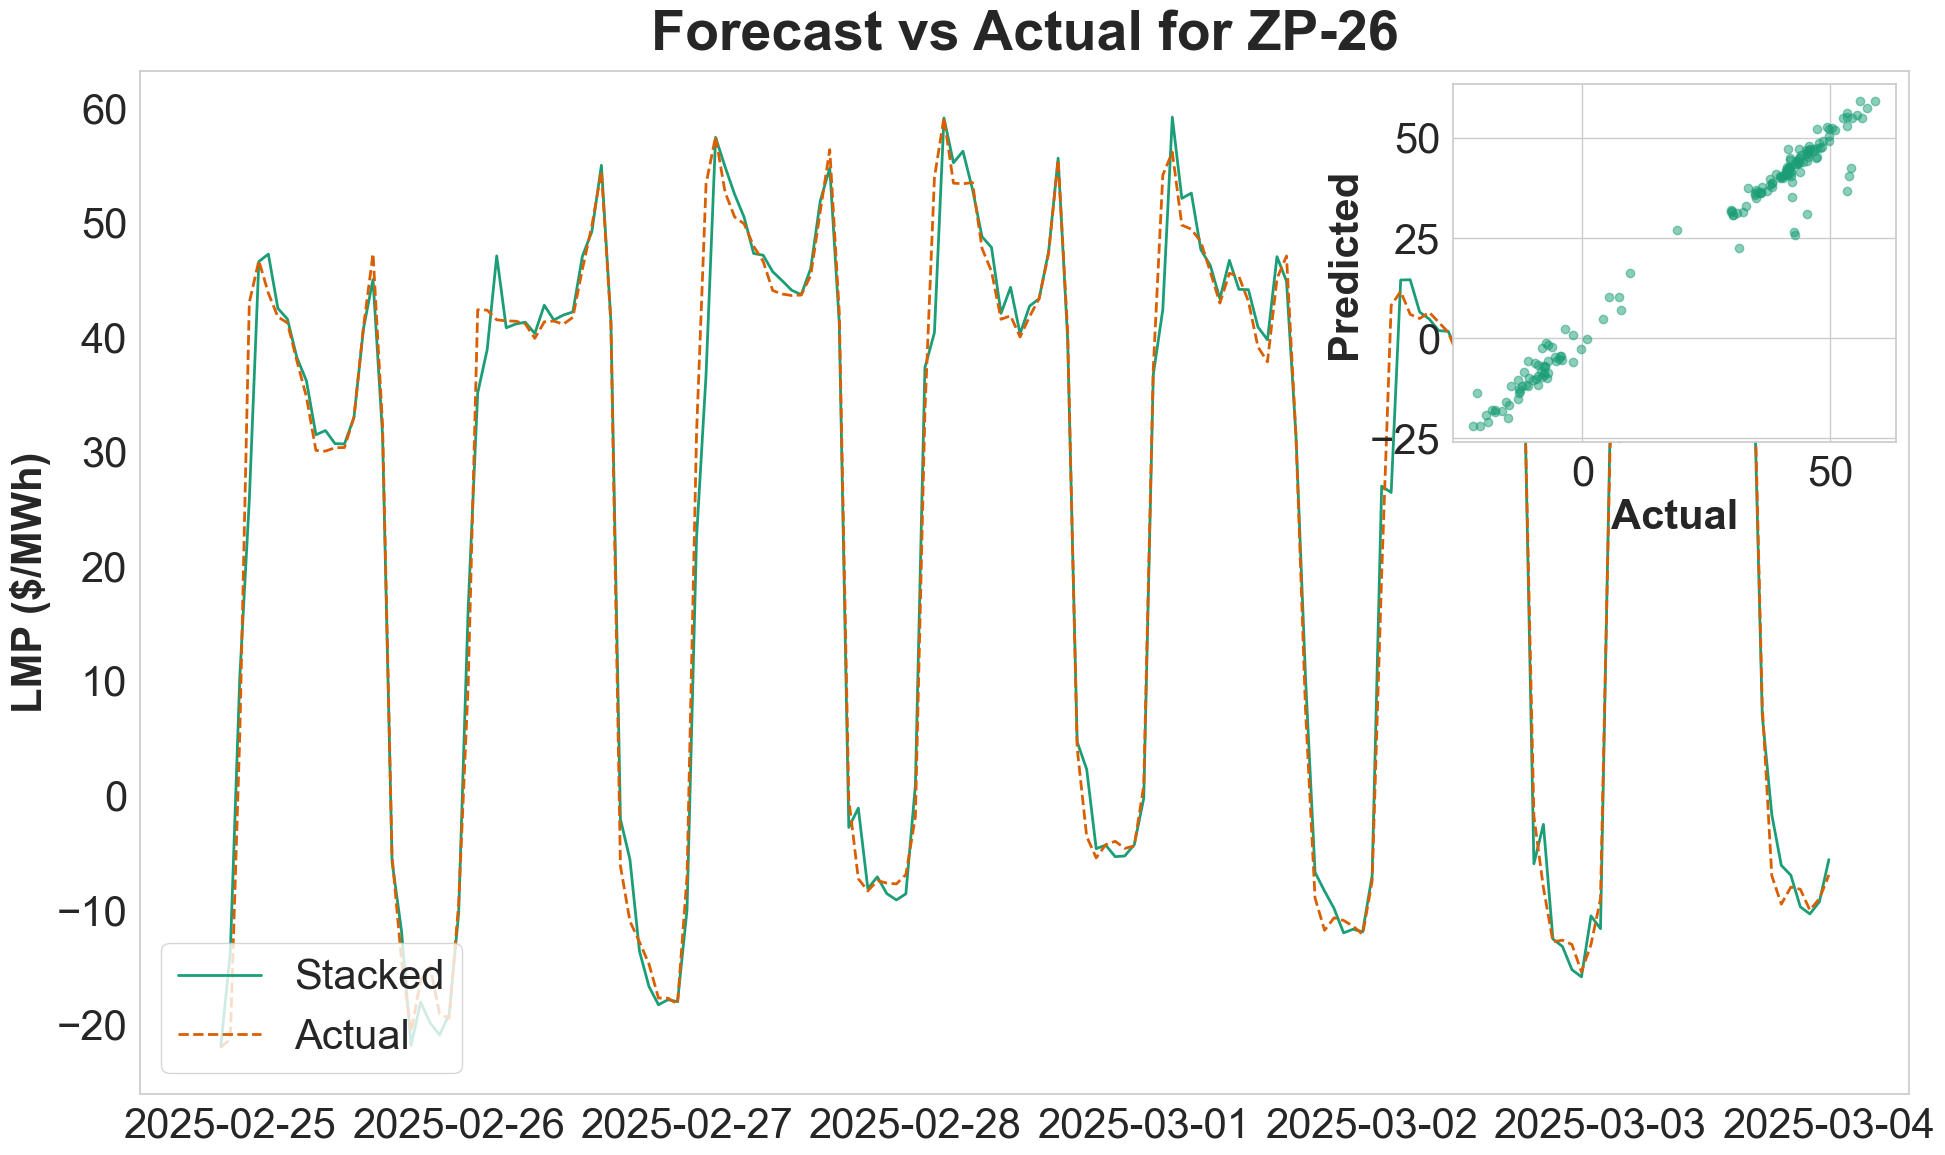

In [13]:
model_name = 'Stacked_model_with_vol'
name = 'Final'

df = imputed_df.copy()
df = winsorize_outliers(df, area_lmp)

df = get_ext_timecols(df)
df_train_complete, df_test_complete = get_train_test(df, split_date, test_end, time_delta)

for j in np.arange(len(areas)):
    
    df_train = df_train_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    df_test = df_test_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    
    lst_arima_train, lst_vol_train = get_res_vol(df_train, area_lmp[j], best_arima_order, best_garch_order)
    lst_arima_test, lst_vol_test = get_res_vol(df_test, area_lmp[j], best_arima_order, best_garch_order)
    
    df_train['ARIMA_res'] = lst_arima_train
    df_train['GARCH_vol'] = lst_vol_train
    
    df_test['ARIMA_res'] = lst_arima_test
    df_test['GARCH_vol'] = lst_vol_test
    
    df_train[f'{areas[j]} Lag'] = df_train[area_lmp[j]].shift(1)
    df_train[f'{areas[j]} Roll'] = df_train[area_lmp[j]].rolling(24).mean()
    df_train[f'{areas[j]} Std'] = df_train[area_lmp[j]].rolling(24).std()
    
    df_test[f'{areas[j]} Lag'] = df_test[area_lmp[j]].shift(1)
    df_test[f'{areas[j]} Roll'] = df_test[area_lmp[j]].rolling(24).mean()
    df_test[f'{areas[j]} Std'] = df_test[area_lmp[j]].rolling(24).std()
    
    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)
    
    X_train = df_train[['ARIMA_res', 'GARCH_vol', 'hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_train = df_train[area_lmp[j]].values
    
    X_test = df_test[['ARIMA_res', 'GARCH_vol', 'hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_test = df_test[area_lmp[j]].values
    
    rf_model = RandomForestRegressor(random_state=42)
    gb_model = XGBRegressor(random_state=42)
    
    # Hyperparameter Tuning
    rf_param_grid = {
        'n_estimators': [100, 200], 
        'max_depth': [5,10]
    }
    
    gb_param_grid = {
        'n_estimators': [100, 200], 
        'learning_rate': [0.01, 0.1],
        'max_depth': [5,10]
    }
    
    meta_features, actual_values = [], []

    for i in range(len(df_test)):
        
        print(f'Simulating {areas[j]} for {df_test.index[i]}')
        
        rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='neg_mean_absolute_error')
        rf_grid.fit(X_train, y_train)
        best_rf = rf_grid.best_estimator_
        
        gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=3, scoring='neg_mean_absolute_error')
        gb_grid.fit(X_train, y_train)
        best_gb = gb_grid.best_estimator_
        
        rf_pred = best_rf.predict([X_test[i]])[0]
        gb_pred = best_gb.predict([X_test[i]])[0]
        
        meta_features.append([rf_pred, gb_pred])
        actual_values.append(y_test[i])
        
        new_data = np.append(X_test[i], y_test[i]).reshape(1,-1)
        X_train = np.vstack([X_train, new_data[:, :-1]])
        y_train = np.append(y_train, new_data[:, -1])
        
    # Training Ridge Regression as the Meta-model
    meta_X = np.array(meta_features)
    meta_y = np.array(actual_values)
    ridge = Ridge(alpha=1.0)
    ridge.fit(meta_X, meta_y)
    stacked_prediction = ridge.predict(meta_X)
    
    comparative_plot1(df_test, areas[j], actual_values, stacked_prediction, var1='Actual', var2='Stacked', name=name)
    
    mae_sp = mean_absolute_error(actual_values, stacked_prediction)
    mse_sp = mean_squared_error(actual_values, stacked_prediction)
    print(f'{areas[j]} - Stacked forecast MAE: {mae_sp:.4f}, MSE: {mse_sp:.4f}')
    
    new_df = pd.DataFrame(index=df_test.index)
    new_df['Actual'] = actual_values
    new_df['Prediction'] = stacked_prediction
    
    new_df.to_csv(file_path + model_name + '_' + areas[j] + '.csv')

### Ensemble and stacked models without volatility

Simulating ZP-26 for 2025-02-24 23:00:00
Simulating ZP-26 for 2025-02-25 00:00:00
Simulating ZP-26 for 2025-02-25 01:00:00
Simulating ZP-26 for 2025-02-25 02:00:00
Simulating ZP-26 for 2025-02-25 03:00:00
Simulating ZP-26 for 2025-02-25 04:00:00
Simulating ZP-26 for 2025-02-25 05:00:00
Simulating ZP-26 for 2025-02-25 06:00:00
Simulating ZP-26 for 2025-02-25 07:00:00
Simulating ZP-26 for 2025-02-25 08:00:00
Simulating ZP-26 for 2025-02-25 09:00:00
Simulating ZP-26 for 2025-02-25 10:00:00
Simulating ZP-26 for 2025-02-25 11:00:00
Simulating ZP-26 for 2025-02-25 12:00:00
Simulating ZP-26 for 2025-02-25 13:00:00
Simulating ZP-26 for 2025-02-25 14:00:00
Simulating ZP-26 for 2025-02-25 15:00:00
Simulating ZP-26 for 2025-02-25 16:00:00
Simulating ZP-26 for 2025-02-25 17:00:00
Simulating ZP-26 for 2025-02-25 18:00:00
Simulating ZP-26 for 2025-02-25 19:00:00
Simulating ZP-26 for 2025-02-25 20:00:00
Simulating ZP-26 for 2025-02-25 21:00:00
Simulating ZP-26 for 2025-02-25 22:00:00
Simulating ZP-26

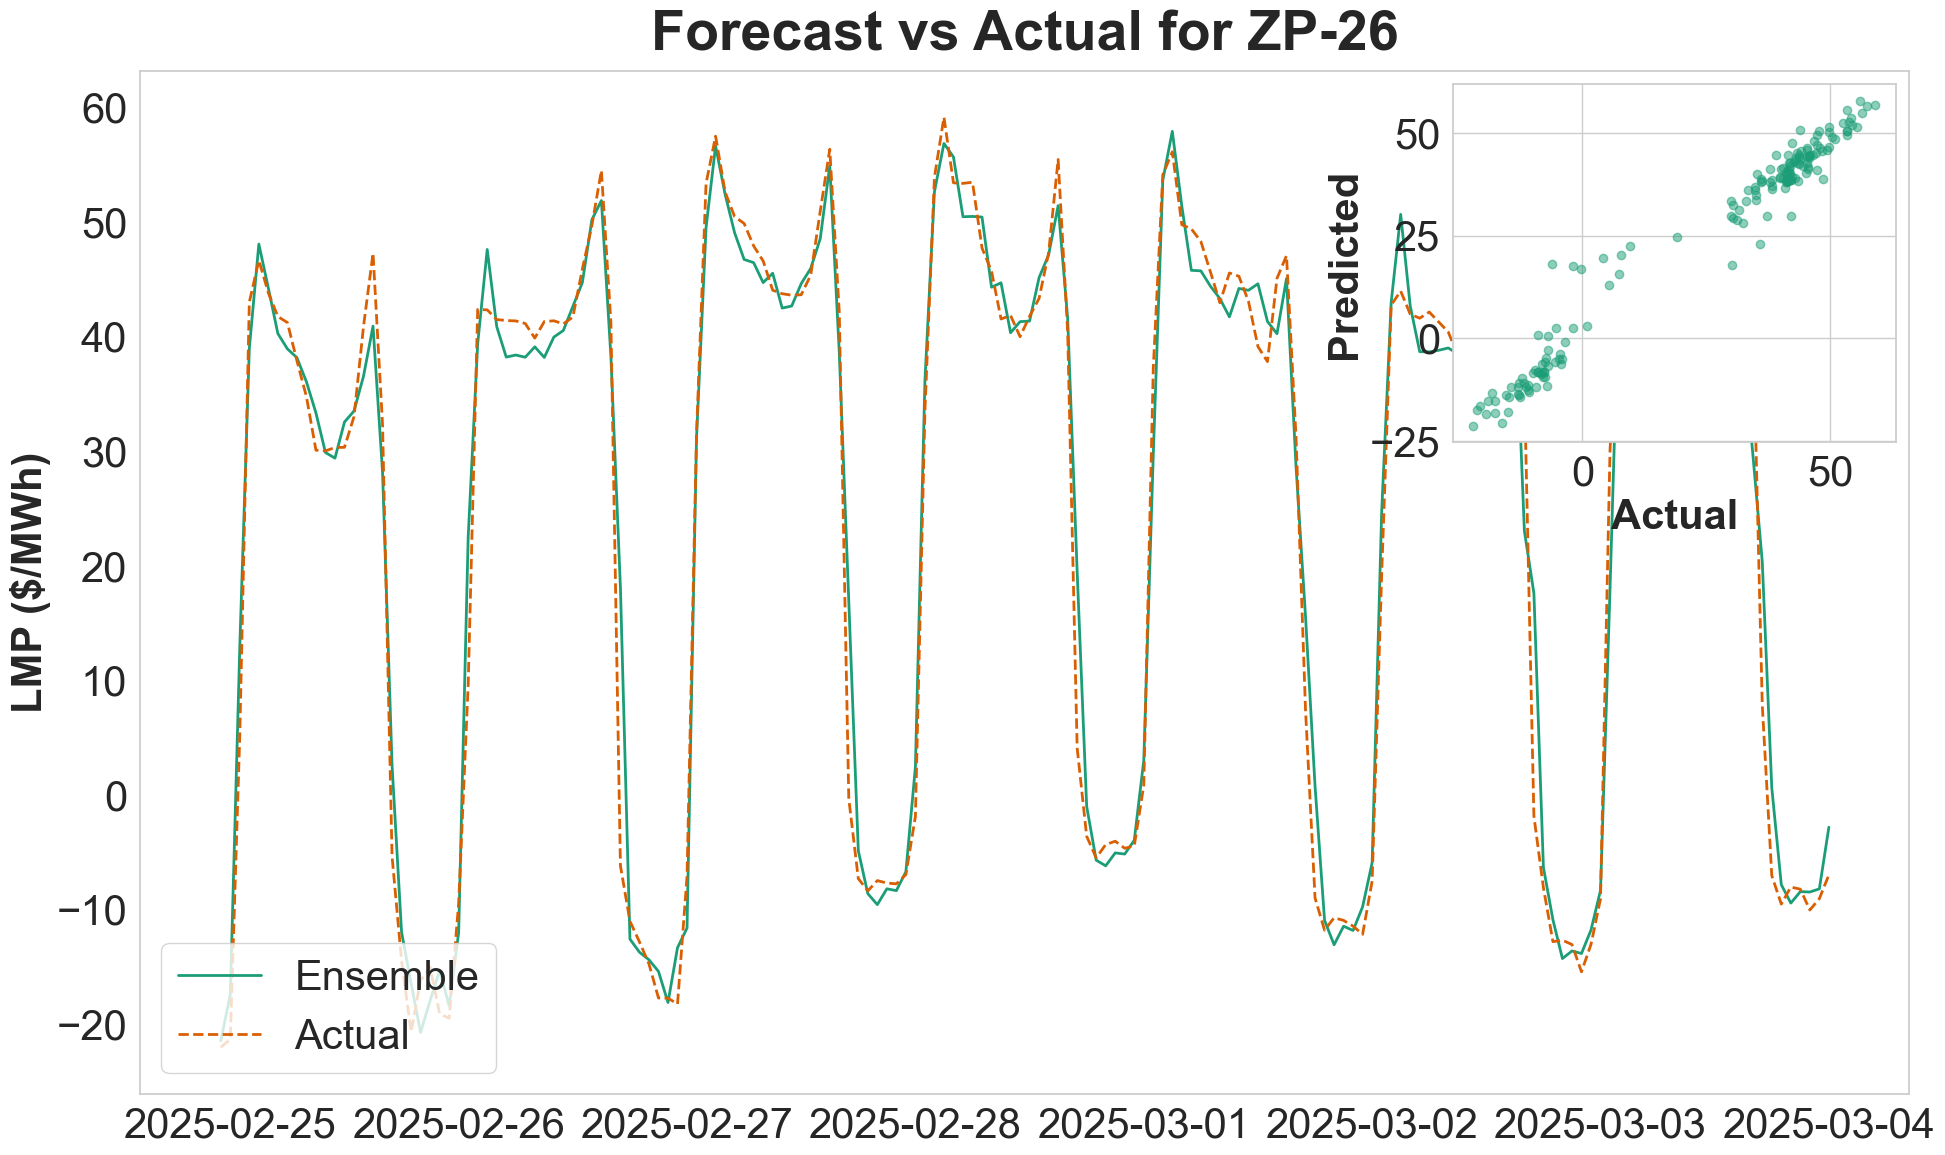

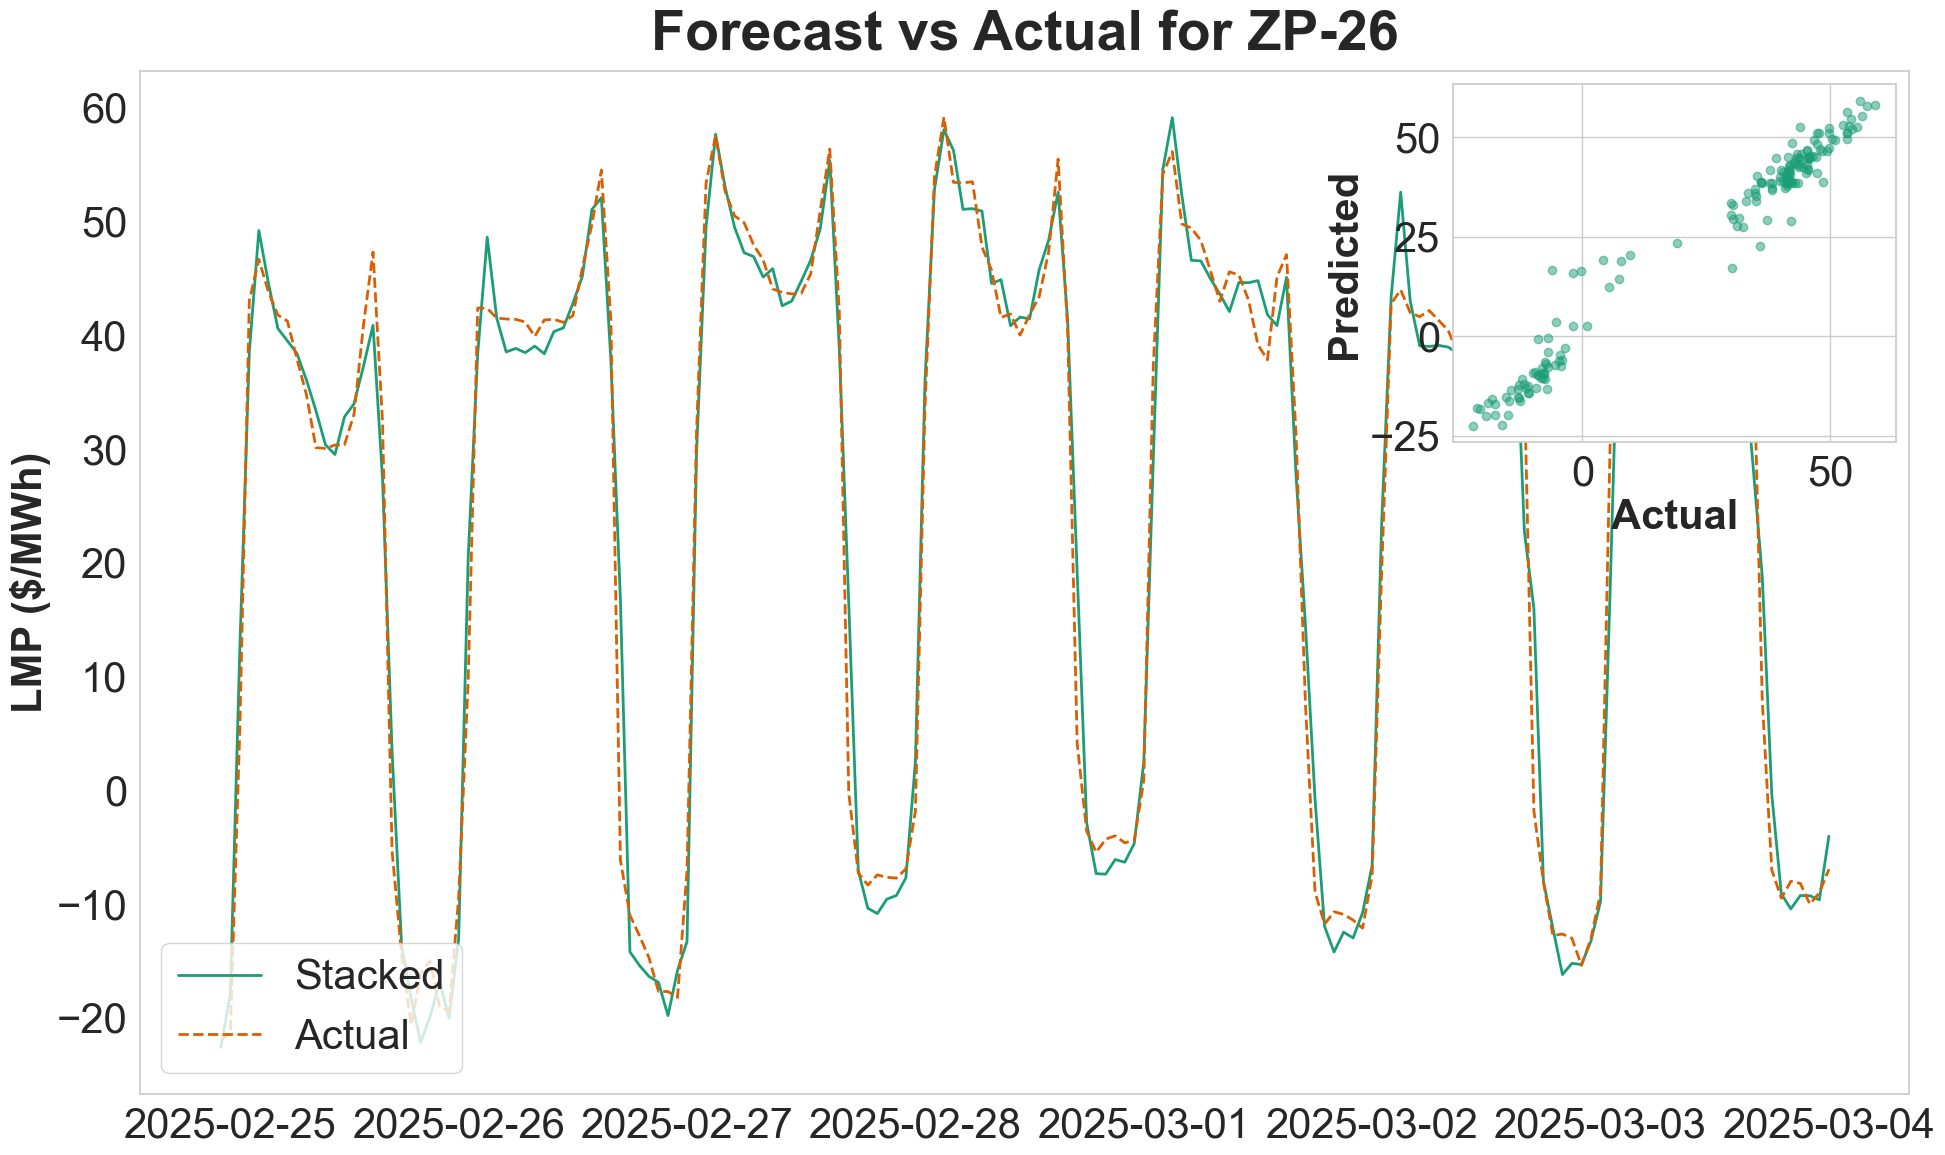

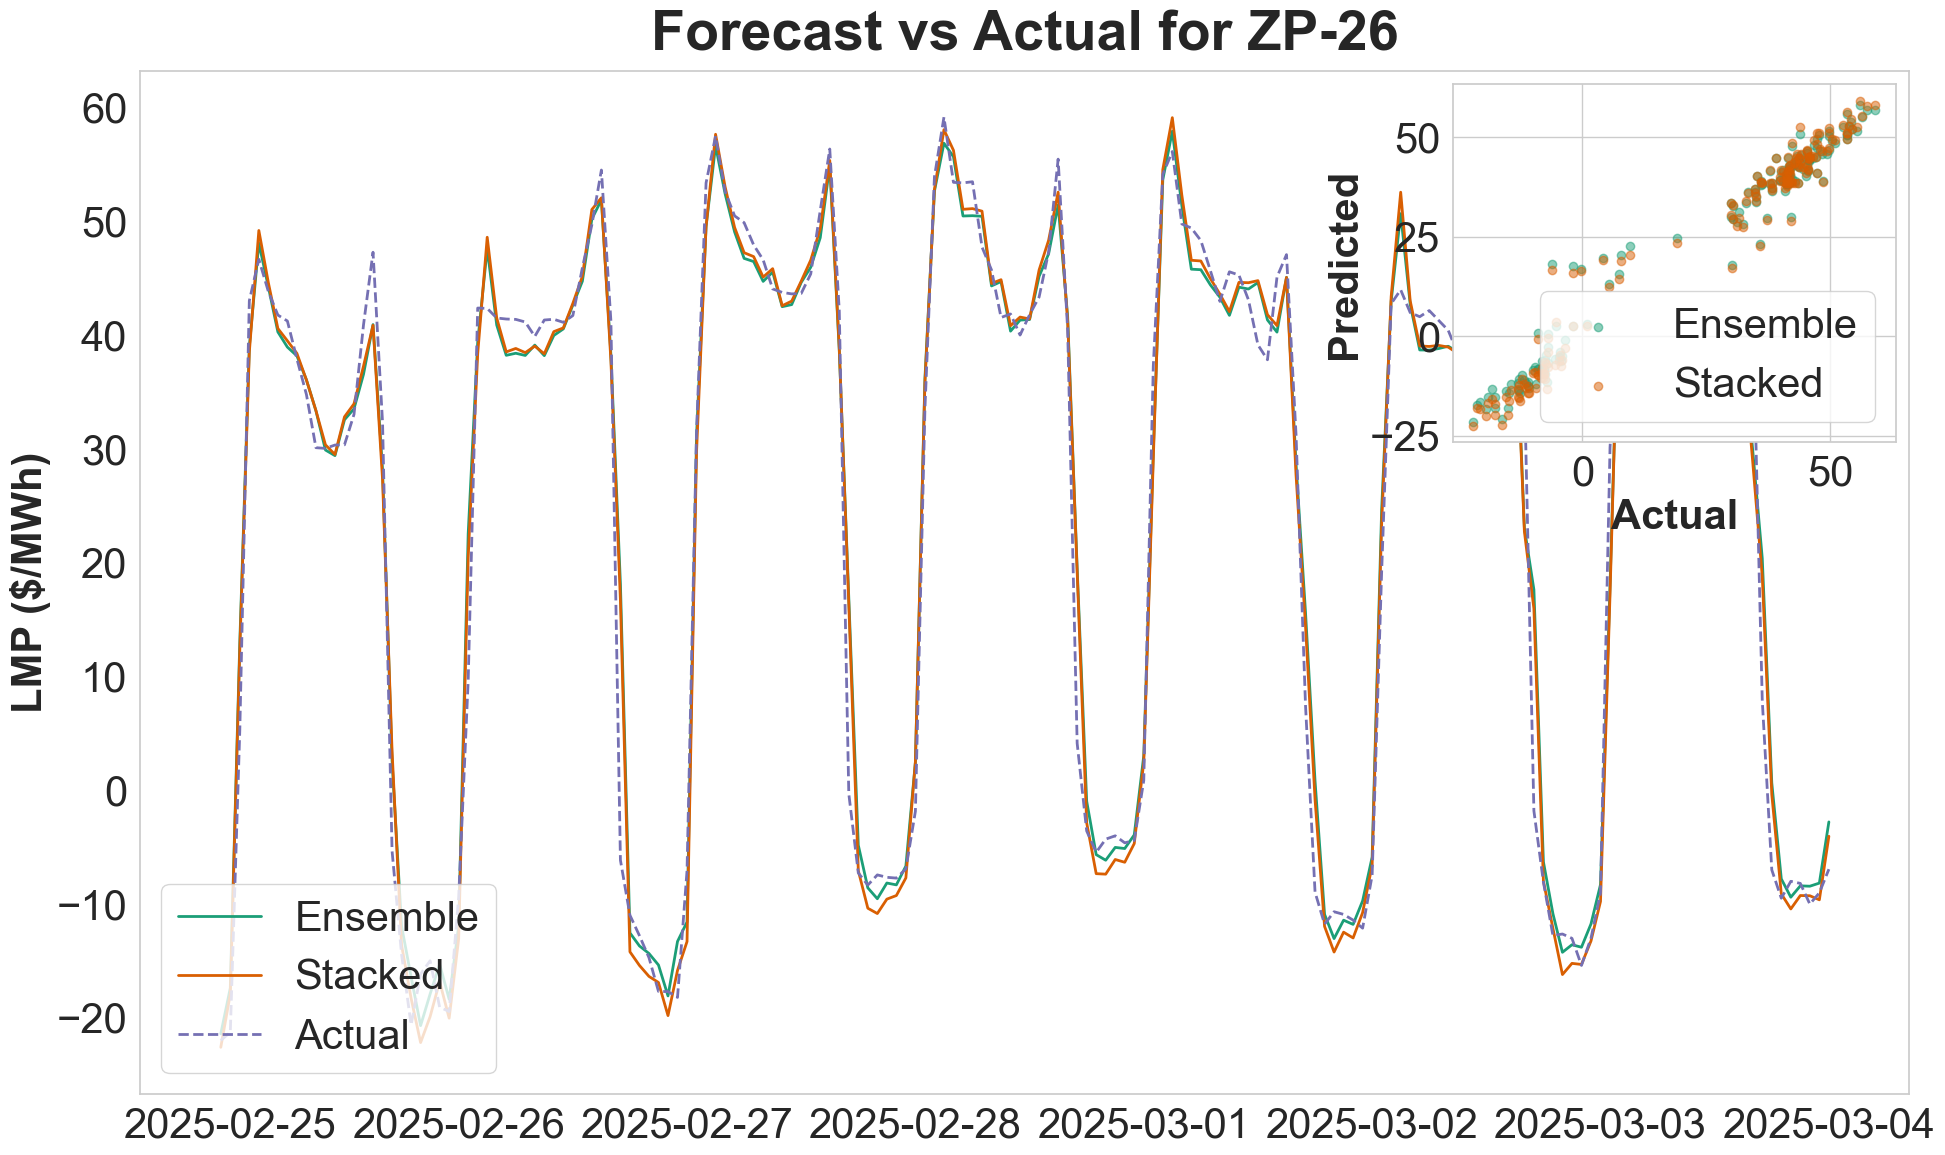

In [15]:
model1_name = 'Ensemble_model'
model2_name = 'Stacked_model'
name = 'Advanced'

wf_rf = 0.7
wf_gb = 1-wf_rf

df = imputed_df.copy()
df = winsorize_outliers(df, area_lmp)

df = get_ext_timecols(df)
df_train_complete, df_test_complete = get_train_test(df, split_date, test_end, time_delta)

for j in np.arange(len(areas)):
    
    df_train = df_train_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    df_test = df_test_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    
    df_train[f'{areas[j]} Lag'] = df_train[area_lmp[j]].shift(1)
    df_train[f'{areas[j]} Roll'] = df_train[area_lmp[j]].rolling(24).mean()
    df_train[f'{areas[j]} Std'] = df_train[area_lmp[j]].rolling(24).std()
    
    df_test[f'{areas[j]} Lag'] = df_test[area_lmp[j]].shift(1)
    df_test[f'{areas[j]} Roll'] = df_test[area_lmp[j]].rolling(24).mean()
    df_test[f'{areas[j]} Std'] = df_test[area_lmp[j]].rolling(24).std()
    
    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)
    
    X_train = df_train[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_train = df_train[area_lmp[j]].values
    
    X_test = df_test[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_test = df_test[area_lmp[j]].values
    
    rf_model = RandomForestRegressor(random_state=42)
    gb_model = XGBRegressor(random_state=42)
    
    # Hyperparameter Tuning
    rf_param_grid = {
        'n_estimators': [100, 200], 
        'max_depth': [5,10]
    }
    
    gb_param_grid = {
        'n_estimators': [100, 200], 
        'learning_rate': [0.01, 0.1],
        'max_depth': [5,10]
    }
    
    ensemble_prediction, actual_values = [], []
    meta_features = []
    
    for i in range(len(df_test)):
        
        print(f'Simulating {areas[j]} for {df_test.index[i]}')
        
        rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='neg_mean_absolute_error')
        rf_grid.fit(X_train, y_train)
        best_rf = rf_grid.best_estimator_
        
        gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=3, scoring='neg_mean_absolute_error')
        gb_grid.fit(X_train, y_train)
        best_gb = gb_grid.best_estimator_
        
        rf_pred = best_rf.predict([X_test[i]])[0]
        gb_pred = best_gb.predict([X_test[i]])[0]
        
        meta_features.append([rf_pred, gb_pred])
        pred = (wf_rf * rf_pred) + (wf_gb * gb_pred)
        
        ensemble_prediction.append(pred)
        actual_values.append(y_test[i])
        
        new_data = np.append(X_test[i], y_test[i]).reshape(1,-1)
        X_train = np.vstack([X_train, new_data[:, :-1]])
        y_train = np.append(y_train, new_data[:, -1])
        
    # Training Ridge Regression as the Meta-model
    meta_X = np.array(meta_features)
    meta_y = np.array(actual_values)
    ridge = Ridge(alpha=1.0)
    ridge.fit(meta_X, meta_y)
    stacked_prediction = ridge.predict(meta_X)

    comparative_plot1(df_test, areas[j], actual_values, ensemble_prediction, var1='Actual', var2='Ensemble', name=name)
    comparative_plot1(df_test, areas[j], actual_values, stacked_prediction, var1='Actual', var2='Stacked', name=name)
    comparative_plot2(df_test, areas[j], actual_values, ensemble_prediction, stacked_prediction, var1='Actual', var2='Ensemble', var3='Stacked', name=name)
    
    mae_en = mean_absolute_error(actual_values, ensemble_prediction)
    mse_en = mean_squared_error(actual_values, ensemble_prediction)
    
    mae_sp = mean_absolute_error(actual_values, stacked_prediction)
    mse_sp = mean_squared_error(actual_values, stacked_prediction)
    
    print(f'{areas[j]} - Ensemble forecast MAE: {mae_en:.4f}, MSE: {mse_en:.4f}')
    print(f'{areas[j]} - Stacked forecast MAE: {mae_sp:.4f}, MSE: {mse_sp:.4f}')
    
    new_df1 = pd.DataFrame(index=df_test.index)
    new_df1['Actual'] = actual_values
    new_df1['Prediction'] = ensemble_prediction
    
    new_df1.to_csv(file_path + model1_name + '_' + areas[j] + '.csv')
    
    new_df2 = pd.DataFrame(index=df_test.index)
    new_df2['Actual'] = actual_values
    new_df2['Prediction'] = stacked_prediction
    
    new_df2.to_csv(file_path + model2_name + '_' + areas[j] + '.csv')